In [1]:
import random
import math
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl

In [2]:
import sys
sys.executable

'/home/liteandfog/anaconda3/envs/pytorch-conda/bin/python'

Set Device

In [3]:
#options are cpu or mps or cuda. 
if torch.cuda.is_available():
    DEVICE=torch.cuda.current_device()
    print(DEVICE)

0


Train GPT on addition

Train a GPT model on a dedicated addition dataset to see if a Transformer can learn to add.

In [4]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

## utils module

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    return x

In [6]:
# make deterministic
set_seed(42)

# torch: Set Dataset

In [7]:
from torch.utils.data import Dataset

class AdditionDataset(Dataset):
    """
    Returns addition problems of up to some number of digits in the inputs. Recall
    that all GPT cares about are sequences of integers, and completing them according to
    patterns in the data. Therefore, we have to somehow encode addition problems
    as a sequence of integers.
    
    The sum of two n-digit numbers gives a third up to (n+1)-digit number. So our
    encoding will simply be the n-digit first number, n-digit second number, 
    and (n+1)-digit result, all simply concatenated together. Because each addition
    problem is so structured, there is no need to bother the model with encoding
    +, =, or other tokens. Each possible sequence has the same length, and simply
    contains the raw digits of the addition problem.
    
    As a few examples, the 2-digit problems:
    - 85 + 50 = 135 becomes the sequence [8, 5, 5, 0, 1, 3, 5]
    - 6 + 39 = 45 becomes the sequence [0, 6, 3, 9, 0, 4, 5]
    etc.
    
    We will also only train GPT on the final (n+1)-digits because the first
    two n-digits are always assumed to be given. So when we give GPT an exam later,
    we will e.g. feed it the sequence [0, 6, 3, 9], which encodes that we'd like
    to add 6 + 39, and hope that the model completes the integer sequence with [0, 4, 5]
    in 3 sequential steps.
    
    fun exercise: does it help if the result is asked to be produced in reverse order?
    """

    def __init__(self, ndigit, split):
        self.split = split # train/test
        self.ndigit = ndigit
        self.vocab_size = 10 # 10 possible digits 0..9
        # +1 due to potential carry overflow, but then -1 because very last digit doesn't plug back
        self.block_size = ndigit + ndigit + ndigit + 1-1
        
        # split up all addition problems into either training data or test data
        num = (10**self.ndigit)**2 # total number of possible combinations
        r = np.random.RandomState(1337) # make deterministic
        perm = r.permutation(num)
        num_test = min(int(num*0.2), 1000) # 20% of the whole dataset, or only up to 1000
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]

    def __len__(self):
        return self.ixes.size

    def __getitem__(self, idx):
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx]
        nd = 10**self.ndigit
        a = idx // nd
        #print(a)
        b = idx %  nd
        #print(b)
        c = a + b
        #print(c)
        render = f'%0{self.ndigit}d%0{self.ndigit}d%0{self.ndigit+1}d' % (a,b,c) # e.g. 03+25=28 becomes "0325028" 
        #print(render)
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long) # predict the next token in the sequence
        y[:self.ndigit*2-1] = -100 # we will only train in the output locations. -100 will mask loss to zero
        return x, y

In [8]:
# create a dataset for e.g. 2-digit addition
ndigit = 2
train_dataset = AdditionDataset(ndigit=ndigit, split='train')
test_dataset = AdditionDataset(ndigit=ndigit, split='test')

In [9]:
len(train_dataset)

9000

In [10]:
train_dataset[0]

(tensor([4, 7, 1, 7, 0, 6]), tensor([-100, -100, -100,    0,    6,    4]))

## GPT model.py

In [11]:
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
        elif isinstance(module, GPT):
            torch.nn.init.normal_(module.pos_emb, mean=0.0, std=0.02)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        #print(x.size())
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

## GPT train.py

In [12]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import math
import logging

from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

logger = logging.getLogger(__name__)

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)
        elif torch.has_mps:
            self.device = torch.device('mps')
            self.model = self.model.to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info("saving %s", self.config.ckpt_path)
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(loader, is_train):
            model.train(is_train)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")

            if not is_train:
                test_loss = float(np.mean(losses))
                logger.info("test loss: %f", test_loss)
                return test_loss

        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay

        train_loader = DataLoader(
            self.train_dataset,
            shuffle=True,
            pin_memory=True,
            batch_size=config.batch_size,
            num_workers=config.num_workers
        )
        if self.test_dataset is not None:
            test_loader = DataLoader(
                self.test_dataset,
                shuffle=True,
                pin_memory=True,
                batch_size=config.batch_size,
                num_workers=config.num_workers
            )

        for epoch in range(config.max_epochs):
            run_epoch(train_loader, is_train=True)
            if self.test_dataset is not None:
                test_loss = run_epoch(test_loader, is_train=False)

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()

# Train GPT

In [13]:
# initialize a baby GPT model
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, 
                  n_layer=2, n_head=4, n_embd=128)
model = GPT(mconf)
#model=model.to(DEVICE)

06/17/2022 16:17:09 - INFO - __main__ -   number of parameters: 4.001280e+05


In [18]:
# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=25, batch_size=512, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=1024, final_tokens=50*len(train_dataset)*(ndigit+1),
                      num_workers=0)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()

epoch 1 iter 17: train loss 0.68773. lr 5.994512e-04: 100%|██████████| 18/18 [00:00<00:00, 34.71it/s]
06/17/2022 16:17:38 - INFO - __main__ -   test loss: 0.537082
epoch 2 iter 17: train loss 0.57210. lr 5.977197e-04: 100%|██████████| 18/18 [00:00<00:00, 38.95it/s]
06/17/2022 16:17:38 - INFO - __main__ -   test loss: 0.418121
epoch 3 iter 17: train loss 0.49818. lr 5.948114e-04: 100%|██████████| 18/18 [00:00<00:00, 40.90it/s]
06/17/2022 16:17:38 - INFO - __main__ -   test loss: 0.352639
epoch 4 iter 17: train loss 0.42640. lr 5.907379e-04: 100%|██████████| 18/18 [00:00<00:00, 41.09it/s]
06/17/2022 16:17:39 - INFO - __main__ -   test loss: 0.268538
epoch 5 iter 17: train loss 0.40540. lr 5.855153e-04: 100%|██████████| 18/18 [00:00<00:00, 41.46it/s]
06/17/2022 16:17:39 - INFO - __main__ -   test loss: 0.232338
epoch 6 iter 17: train loss 0.38801. lr 5.791641e-04: 100%|██████████| 18/18 [00:00<00:00, 40.66it/s]
06/17/2022 16:17:40 - INFO - __main__ -   test loss: 0.199030
epoch 7 iter 17:

In [19]:
# now let's give the trained model an addition exam
from torch.utils.data.dataloader import DataLoader

def give_exam(dataset, batch_size=32, max_batches=-1):
    
    results = []
    loader = DataLoader(dataset, batch_size=batch_size)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        d1d2 = x[:, :ndigit*2]
        d1d2d3 = sample(model, d1d2, ndigit+1)
        d3 = d1d2d3[:, -(ndigit+1):]
        factors = torch.tensor([[10**i for i in range(ndigit+1)][::-1]]).to(trainer.device)
        # decode the integers from individual digits
        d1i = (d1d2[:,:ndigit] * factors[:,1:]).sum(1)
        d2i = (d1d2[:,ndigit:ndigit*2] * factors[:,1:]).sum(1)
        d3i_pred = (d3 * factors).sum(1)
        d3i_gt = d1i + d2i
        correct = (d3i_pred == d3i_gt).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line, lol
        for i in range(x.size(0)):
            results.append(int(correct[i]))
            judge = 'YEP!!!' if correct[i] else 'NOPE'
            if not correct[i]:
                print("GPT claims that %03d + %03d = %03d (gt is %03d; %s)" 
                      % (d1i[i], d2i[i], d3i_pred[i], d3i_gt[i], judge))
        
        if max_batches >= 0 and b+1 >= max_batches:
            break

    print("final score: %d/%d = %.2f%% correct" % (np.sum(results), len(results), 100*np.mean(results)))

In [20]:
# training set: how well did we memorize?
give_exam(train_dataset, batch_size=1024, max_batches=10)

final score: 9000/9000 = 100.00% correct


In [21]:
# test set: how well did we generalize?
give_exam(test_dataset, batch_size=1024, max_batches=-1)

GPT claims that 091 + 099 = 180 (gt is 190; NOPE)
final score: 999/1000 = 99.90% correct


# Understanding Karapathy's minGPT..

In [22]:
# show params
print(vars(train_dataset))
vars(mconf)

{'split': 'train', 'ndigit': 2, 'vocab_size': 10, 'block_size': 6, 'ixes': array([4717, 3455, 1827, ...,  860, 8381, 3223])}


{'vocab_size': 10, 'block_size': 6, 'n_layer': 2, 'n_head': 4, 'n_embd': 128}

In [23]:
### dataloader

from torch.utils.data.dataloader import DataLoader
train_loader = DataLoader(
            train_dataset,
            shuffle=True,
            pin_memory=True,
            batch_size=tconf.batch_size,
            num_workers=0
        )

x, y = next(iter(train_loader)) 

print(x.size())

class Embedder:
    """ simple aux class to embed data entry """  
    
    def __init__(self,x):
        self.emb=nn.Embedding(10, 128)
        self.x=x
    def __call__(self):
        return self.emb(self.x)
    
    
x =Embedder(x)()
B,T,C=x.size() 

print("BS,inpute size, embedded dimension:",B,T,C)

torch.Size([512, 6])
BS,inpute size, embedded dimension: 512 6 128


In [24]:
torch.tril(torch.ones(6, 6)) # Returns the lower triangular part of the matrix (2-D tensor) 

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

In [25]:
x.size()

torch.Size([512, 6, 128])

#### torch.Tensor.view(): Returns a new tensor with the same data as the self tensor but of a different shape.



(B, nh, T, hs) = (batch size,number of heads,sequence length,embedding dimentions per head)

In [26]:
x.size()

torch.Size([512, 6, 128])

In [27]:
# attension matrices (trainable)
key = nn.Linear(mconf.n_embd, mconf.n_embd)
query = nn.Linear(mconf.n_embd, mconf.n_embd)
value = nn.Linear(mconf.n_embd, mconf.n_embd)

# calculate query, key, values for all heads in batch and move head forward to be the batch dim
k = key(x).view(B, T, mconf.n_head, C // mconf.n_head).transpose(1, 2) # (B, nh, T, hs)
q = query(x).view(B, T, mconf.n_head, C // mconf.n_head).transpose(1, 2) # (B, nh, T, hs)
v = value(x).view(B, T, mconf.n_head, C // mconf.n_head).transpose(1, 2) # (B, nh, T, hs)

##Attention's Layer:

#similarity
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

#casual masking
att = att.masked_fill(torch.tril(torch.ones(mconf.block_size, mconf.block_size))
         .view(1, 1, mconf.block_size, mconf.block_size)[:,:,:T,:T] == 0, float('-inf'))

#print(att[0,0])
#softmax
att = F.softmax(att, dim=-1)
#print(att[0,0])
att = nn.Dropout(mconf.attn_pdrop)(att)
#print(att[0,0])
y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

# output projection
y = nn.Dropout(mconf.resid_pdrop)(nn.Linear(mconf.n_embd, mconf.n_embd)(y))

assert x.size()== y.size()

In [28]:
print(x.shape)

torch.Size([512, 6, 128])


In [29]:
nn.GELU()(torch.Tensor([5])) # x*(CMF of normal distribution)

tensor([5.0000])

In [30]:
for x,i in enumerate(model.named_modules()):
    print(x,i)

0 ('', GPT(
  (tok_emb): Embedding(10, 128)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=128, out_features=128, bias=True)
        (query): Linear(in_features=128, out_features=128, bias=True)
        (value): Linear(in_features=128, out_features=128, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU()
        (2): Linear(in_features=512, out_features=128, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  

# Graph visualization; dummy run

In [31]:
from torchviz import make_dot

In [32]:
loader = DataLoader(train_dataset, batch_size=32)
x,y = next(iter(loader))
x = x.to(trainer.device)
d1d2 = x[:, :ndigit*2]
make_dot(model(d1d2)[0], params=dict(list(model.named_parameters()))).render("mingpt_torchviz", format="png")

'mingpt_torchviz.png'

In [33]:
model(d1d2)[0].size()

torch.Size([32, 4, 10])

In [34]:
d1d2

tensor([[4, 7, 1, 7],
        [3, 4, 5, 5],
        [1, 8, 2, 7],
        [9, 2, 0, 1],
        [8, 6, 2, 8],
        [8, 6, 3, 0],
        [4, 7, 3, 3],
        [6, 1, 8, 0],
        [8, 6, 8, 1],
        [3, 2, 0, 2],
        [9, 0, 5, 7],
        [4, 4, 7, 2],
        [6, 6, 7, 0],
        [7, 1, 3, 5],
        [3, 8, 9, 0],
        [2, 2, 8, 6],
        [8, 1, 5, 1],
        [0, 1, 6, 6],
        [2, 2, 8, 5],
        [9, 3, 9, 8],
        [1, 7, 6, 8],
        [7, 0, 6, 5],
        [6, 6, 6, 6],
        [0, 1, 7, 3],
        [4, 1, 9, 8],
        [3, 3, 1, 0],
        [9, 0, 8, 6],
        [0, 9, 0, 0],
        [6, 0, 6, 5],
        [3, 9, 6, 3],
        [6, 3, 9, 6],
        [8, 1, 2, 4]], device='cuda:0')

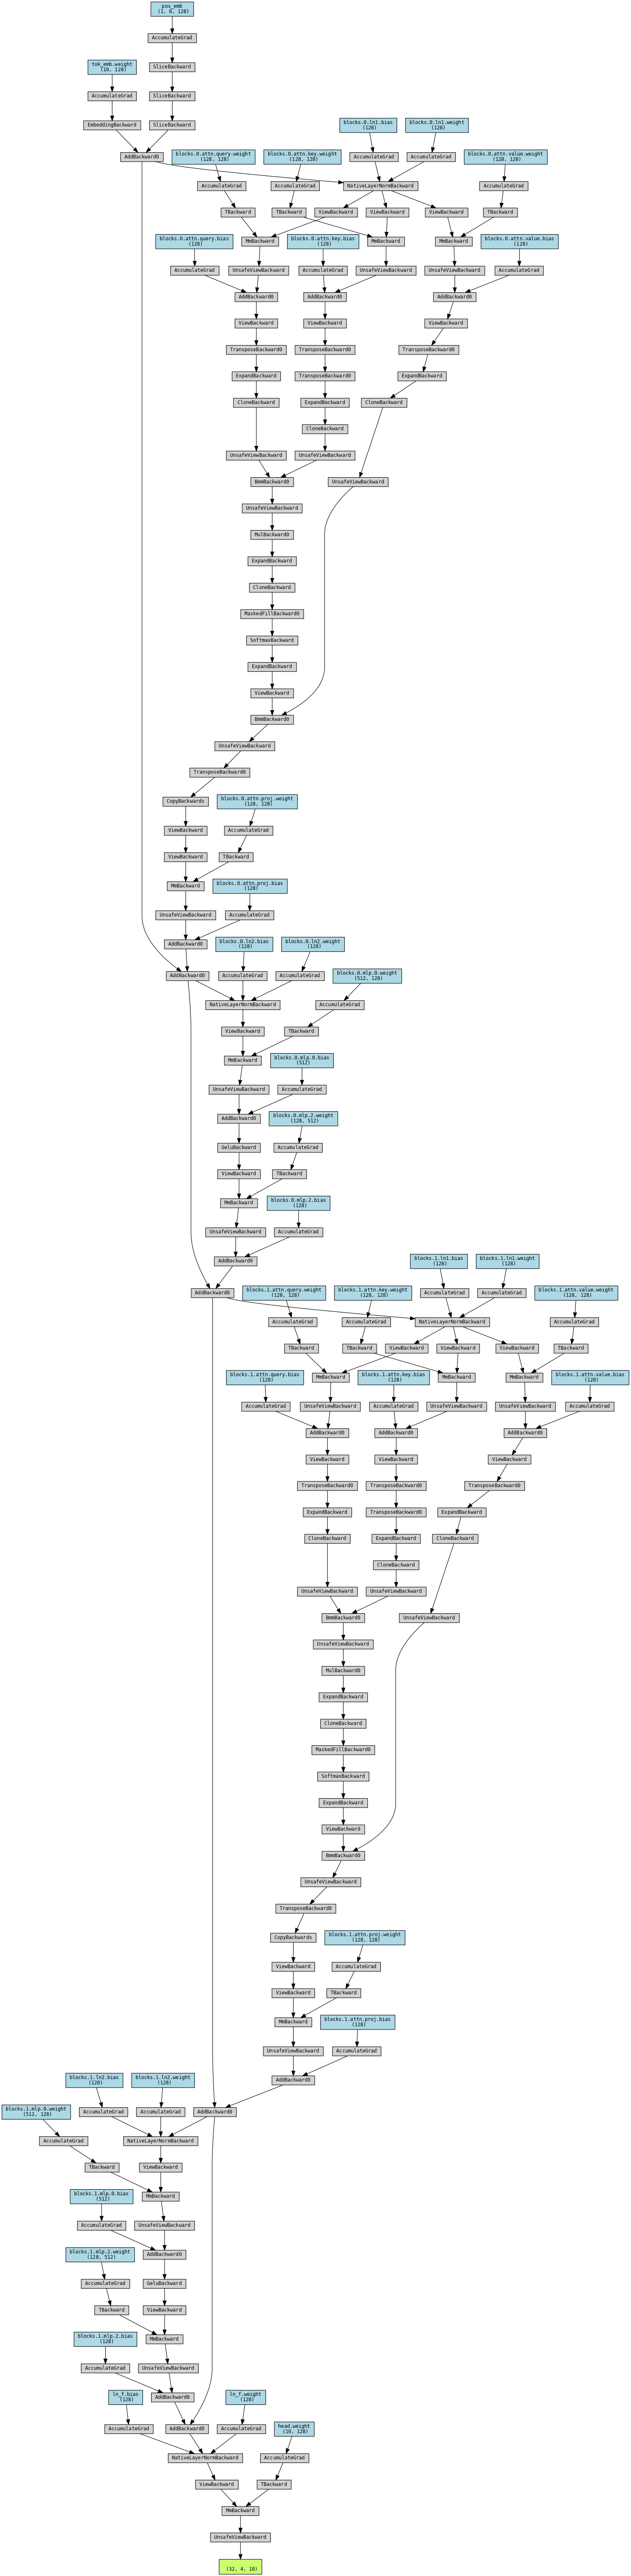

In [35]:
from IPython.display import Image
Image(filename='mingpt_torchviz.png') 

In [37]:
for param in model.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([1, 6, 128])
<class 'torch.Tensor'> torch.Size([10, 128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128, 128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128, 128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128, 128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128, 128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([512, 128])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([128, 512])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128, 128])
<class 'torc